In [1]:
import sys
sys.path.append('..')
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sympy import simplify_logic

from deep_logic.utils.relunn import get_reduced_model, prune_features
from deep_logic import fol
from deep_logic.utils.base import collect_parameters

torch.manual_seed(0)
np.random.seed(0)

In [2]:
gene_expression_matrix = pd.read_csv('w_1/data_0.csv', index_col=None, header=None)
labels = pd.read_csv('w_1/tempLabels_W-1.csv', index_col=None, header=None)
genes = pd.read_csv('w_1/features_0.csv', index_col=None, header=None)

In [3]:
gene_expression_matrix

,0,1,2,3,4,5,6,7,8,9,...,28392,28393,28394,28395,28396,28397,28398,28399,28400,28401
0,14.622486,11.162004,3.320000,3.320000,3.320000,12.788433,6.143456,3.320000,4.876620,3.320000,...,3.32,3.320000,3.885589,3.914260,3.320000,3.32,3.320000,4.465420,3.320000,4.973620
1,14.398743,11.000080,3.320000,3.320000,3.320000,12.845914,6.147482,3.320000,4.484223,3.320000,...,3.32,3.575025,4.236519,4.047825,3.320000,3.32,4.176269,3.320000,4.553796,4.967418
2,14.692079,11.100175,3.320000,4.171535,3.320000,12.712544,5.583210,3.320000,3.478171,3.320000,...,3.32,3.320000,3.992331,4.865538,3.320000,3.32,3.488281,3.406285,3.320000,6.676063
3,14.613382,11.023209,3.320000,3.320000,3.320000,12.750496,5.688023,3.320000,4.464426,3.320000,...,3.32,3.855643,3.320000,4.905350,3.320000,3.32,4.158393,4.433457,3.874214,5.981160
4,14.482065,10.989851,3.320000,3.992726,4.574745,12.878702,6.195418,4.177962,3.872567,3.320000,...,3.32,3.320000,3.320000,4.879493,3.320000,3.32,4.571869,3.320000,4.982136,6.145585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,14.565031,11.699843,3.320000,3.320000,3.320000,12.789212,6.504027,3.320000,3.320000,6.182912,...,3.32,3.320000,3.320000,4.338456,3.771718,3.32,3.320000,3.320000,3.320000,6.100644
57,14.624502,11.918757,3.320000,4.292406,3.430485,10.728709,6.197159,3.320000,4.089918,5.201608,...,3.32,3.320000,3.320000,4.790134,3.320000,3.32,4.985474,4.444057,3.580523,6.301926
58,14.585190,11.090112,3.320000,3.674768,3.320000,12.877485,6.326960,3.320000,3.320000,3.320000,...,3.32,3.320000,3.320000,4.547342,3.320000,3.32,4.064473,3.320000,4.254152,5.964505
59,14.449554,10.805855,3.320000,3.320000,3.320000,12.660038,6.261395,3.320000,4.125096,3.320000,...,3.32,3.784260,3.644823,4.546974,3.427441,3.32,4.666265,3.888525,3.765754,5.452018


In [4]:
labels

,0
0,diagnosis: healthy control
1,diagnosis: healthy control
2,diagnosis: healthy control
3,diagnosis: healthy control
4,diagnosis: healthy control
...,...
56,omalizumab responder status: Responder
57,omalizumab responder status: Responder
58,omalizumab responder status: Responder
59,omalizumab responder status: Responder


In [5]:
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels.values)
labels_encoded_noncontrols = labels_encoded[labels_encoded!=0] - 1

data_controls = gene_expression_matrix[labels_encoded==0]
data = gene_expression_matrix[labels_encoded!=0]

gene_signature = data_controls.mean(axis=0)
data_scaled = data - gene_signature

scaler = MinMaxScaler((0, 1))
scaler.fit(data_scaled)
data_normalized = scaler.transform(data_scaled)

x = torch.FloatTensor(data_normalized)
y = torch.FloatTensor(labels_encoded_noncontrols).unsqueeze(1)
print(x.shape)
print(y.shape)

c:\users\pietr\anaconda3\envs\deep-logic\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


torch.Size([40, 28402])
torch.Size([40, 1])


In [31]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
y = y.to(device)

layers = [
    torch.nn.Linear(x.size(1), 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Sigmoid(),
]
model = torch.nn.Sequential(*layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()
need_pruning = True
for epoch in range(15000):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x)
    # Compute Loss
    loss = torch.nn.functional.mse_loss(y_pred, y)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.01 * torch.norm(module.weight, 1)
            loss += 0.01 * torch.norm(module.bias, 1)

    # backward pass
    loss.backward()
    optimizer.step()

    # compute accuracy
    if epoch % 1000 == 0:
        y_pred_d = (y_pred > 0.5)
        accuracy = (y_pred_d.eq(y).sum(dim=1) == y.size(1)).sum().item() / y.size(0)
        print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')
        
    if epoch > 8000 and need_pruning and epoch % 1000 == 0:
        prune_features(model, 1, device)
        need_pruning = True

Epoch 0: train accuracy: 0.2250
Epoch 1000: train accuracy: 0.7500
Epoch 2000: train accuracy: 0.7500
Epoch 3000: train accuracy: 0.7500
Epoch 4000: train accuracy: 0.9500
Epoch 5000: train accuracy: 0.9750
Epoch 6000: train accuracy: 1.0000
Epoch 7000: train accuracy: 1.0000
Epoch 8000: train accuracy: 1.0000
Epoch 9000: train accuracy: 1.0000
Epoch 10000: train accuracy: 1.0000
Epoch 11000: train accuracy: 1.0000
Epoch 12000: train accuracy: 1.0000
Epoch 13000: train accuracy: 1.0000
Epoch 14000: train accuracy: 1.0000


## Local explanations

In [7]:
np.set_printoptions(precision=2, suppress=True)
outputs = []
for i, (xin, yin) in enumerate(zip(x, y)):
    model_reduced = get_reduced_model(model, xin.to(device)).to(device)
    for module in model_reduced.children():
        if isinstance(module, torch.nn.Linear):
            wa = module.weight.cpu().detach().numpy()
            break
    output = model_reduced(xin)
    
    pred_class = torch.argmax(output)
    true_class = torch.argmax(y[i])

    # generate local explanation only if the prediction is correct
    if pred_class.eq(true_class):
        local_explanation = fol.relunn.explain_local(model.to(device), x, y, xin, yin, device=device)
        print(f'Input {(i+1)}')
        print(f'\tx={xin.cpu().detach().numpy()}')
        print(f'\ty={y[i].cpu().detach().numpy()}')
        print(f'\ty={output.cpu().detach().numpy()}')
        #print(f'\tw={wa}')
        print(f'\tExplanation: {local_explanation}')
        print()
    outputs.append(output)

Input 1
	x=[0.94 0.31 0.   ... 0.26 0.8  0.68]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & ~feature0000010382 & ~feature0000013464 & feature0000013710 & feature0000022010 & ~feature0000025379 & ~feature0000026329

Input 2
	x=[0.84 0.71 0.   ... 0.26 0.   0.62]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000026329

Input 3
	x=[0.62 0.36 0.   ... 0.   0.   0.71]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & ~feature0000010382 & ~feature0000013464 & ~feature0000013710 & ~feature0000022010 & ~feature0000025379 & feature0000026329

Input 4
	x=[0.81 0.95 0.   ... 0.83 0.   0.95]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & feature0000013710 & ~feature0000026329

Input 5
	x=[0.   0.68 0.   ... 0.43 0.   0.89]
	y=[0.]
	y=[0.99]
	Explanation: ~feature0000006749 & ~feature0000010382 & ~feature0000013464 & ~feature0000013710 & ~feature0000022010 & ~feature0000025379 & ~feature0000026329

Input 6
	x=[0.79 0.65 0.   ... 0.3  0.   0.69]
	y=[0.]
	y=[0.99]
	Explanation: 

Input 7


# Combine local explanations

In [8]:
dummy_names = [f'g{i}' for i in range(x.shape[1])]

In [9]:
concept_names = genes.values.squeeze()
concept_names

array(['ILMN_1343291', 'ILMN_1343295', 'ILMN_1651199', ...,
       'ILMN_3311165', 'ILMN_3311180', 'ILMN_3311190'], dtype=object)

In [10]:
from sklearn.preprocessing import OneHotEncoder
y1h = OneHotEncoder(sparse=False).fit_transform(y.cpu().detach().numpy())
y2 = torch.FloatTensor(y1h).to(device)

In [36]:
global_explanation, predictions, counter = fol.combine_local_explanations(model, 
                                                                          x=x, y=y2, is_pruned=True, 
                                                                          target_class=0,
                                                                          topk_explanations=8,
                                                                          device=device)

accuracy, preds = fol.base.test_explanation(global_explanation, 0, x, y)
final_formula = fol.base.replace_names(global_explanation, concept_names)
final_formula_with_dummies = fol.base.replace_names(global_explanation, dummy_names)
print(f'Accuracy of when using the formula "{final_formula}": {accuracy:.4f}\n')
print(f'Accuracy of when using the formula "{final_formula_with_dummies}": {accuracy:.4f}')

Accuracy of when using the formula "(ILMN_1777811 & ILMN_2241168 & ~ILMN_1708983 & ~ILMN_1745049 & ~ILMN_3228700 & ~ILMN_3243714) | (ILMN_3243714 & ~ILMN_1708983 & ~ILMN_1745049 & ~ILMN_1777811 & ~ILMN_2241168 & ~ILMN_3228700) | (~ILMN_1708983 & ~ILMN_1775520 & ~ILMN_1777811 & ~ILMN_2241168 & ~ILMN_3228700 & ~ILMN_3243714)": 0.9250

Accuracy of when using the formula "(g13710 & g22010 & ~g6749 & ~g10382 & ~g25379 & ~g26329) | (g26329 & ~g6749 & ~g10382 & ~g13710 & ~g22010 & ~g25379) | (~g6749 & ~g13464 & ~g13710 & ~g22010 & ~g25379 & ~g26329)": 0.9250


In [35]:
global_explanation, predictions, counter = fol.combine_local_explanations(model, 
                                                                          x=x, y=y2, is_pruned=True, 
                                                                          target_class=1,
                                                                          topk_explanations=15,
                                                                          device=device)

accuracy, preds = fol.base.test_explanation(global_explanation, 1, x, y)
final_formula = fol.base.replace_names(global_explanation, concept_names)
final_formula_with_dummies = fol.base.replace_names(global_explanation, dummy_names)
print(f'Accuracy of when using the formula "{final_formula}": {accuracy:.4f}\n')
print(f'Accuracy of when using the formula "{final_formula_with_dummies}": {accuracy:.4f}')

Accuracy of when using the formula "(ILMN_1745049 & ILMN_1777811 & ~ILMN_1708983 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1745049 & ILMN_3243714 & ~ILMN_1708983 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1777811 & ILMN_3243714 & ~ILMN_1708983 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1745049 & ILMN_1777811 & ILMN_3228700 & ILMN_3243714 & ~ILMN_1775520 & ~ILMN_2241168) | (ILMN_1708983 & ILMN_1745049 & ILMN_2241168 & ILMN_3228700 & ILMN_3243714 & ~ILMN_1775520 & ~ILMN_1777811) | (ILMN_1708983 & ILMN_3243714 & ~ILMN_1745049 & ~ILMN_1775520 & ~ILMN_2241168 & ~ILMN_3228700) | (ILMN_1708983 & ILMN_1775520 & ILMN_1777811 & ~ILMN_1745049 & ~ILMN_2241168 & ~ILMN_3228700 & ~ILMN_3243714) | (ILMN_1708983 & ILMN_1777811 & ILMN_2241168 & ~ILMN_1745049 & ~ILMN_1775520 & ~ILMN_3228700 & ~ILMN_3243714) | (ILMN_1708983 & ILMN_1745049 & ~ILMN_1775520 & ~ILMN_1777811 & ~ILMN_2241168 & ~ILMN_3228700 & ~ILMN_3243714)": 0.9250

Accuracy of when using the formula "(g10382 & g13710 & ~g6749 & ~g13464 & ~g22010) 

In [13]:
w, b = collect_parameters(model, device)
feature_weights = w[0]
feature_used_bool = np.sum(np.abs(feature_weights), axis=0) > 0
feature_used = np.nonzero(feature_used_bool)[0]
genes.iloc[feature_used]

,0
6749,ILMN_1708983
10382,ILMN_1745049
13464,ILMN_1775520
13710,ILMN_1777811
22010,ILMN_2241168
25379,ILMN_3228700
26329,ILMN_3243714


In [14]:
global_explanation2 = fol.relunn.explain_global(model, n_classes=1, target_class=0, device=device)
explanation = fol.relunn.explain_global(model, n_classes=1, target_class=0, device=device)
if explanation not in ['False', 'True', 'The formula is too complex!']:
    accuracy, _ = fol.relunn.test_explanation(explanation, target_class=0, x=x.cpu(), y=y.cpu())
    print(f'Class {0} - Global explanation: "{global_explanation2}" - Accuracy: {accuracy:.4f}')

Class 0 - Global explanation: "(feature0000006749 & feature0000010382 & feature0000013710) | (feature0000006749 & feature0000010382 & feature0000025379) | (feature0000006749 & feature0000010382 & feature0000026329) | (feature0000006749 & feature0000013710 & feature0000025379) | (feature0000006749 & feature0000013710 & feature0000026329) | (feature0000006749 & feature0000025379 & feature0000026329) | (feature0000010382 & feature0000013710 & feature0000025379) | (feature0000010382 & feature0000013710 & feature0000026329) | (feature0000010382 & feature0000025379 & feature0000026329) | (feature0000013710 & feature0000025379 & feature0000026329) | (feature0000006749 & feature0000010382 & ~feature0000013464) | (feature0000006749 & feature0000010382 & ~feature0000022010) | (feature0000006749 & feature0000013710 & ~feature0000013464) | (feature0000006749 & feature0000013710 & ~feature0000022010) | (feature0000006749 & feature0000025379 & ~feature0000022010) | (feature0000006749 & feature000002

## From previous works

ILMN_3286286, **ILMN_1775520**, ILMN_1656849, ILMN_1781198, ILMN_1665457

# Cross validation

In [15]:
def train_nn(x_train, y_train, layers, device):
    torch.manual_seed(0)
    np.random.seed(0)
    model = torch.nn.Sequential(*layers).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.train()
    need_pruning = True
    for epoch in range(15000):
        # forward pass
        optimizer.zero_grad()
        y_pred = model(x_train)
        # Compute Loss
        loss = torch.nn.functional.mse_loss(y_pred, y_train)

        for module in model.children():
            if isinstance(module, torch.nn.Linear):
                loss += 0.01 * torch.norm(module.weight, 1)
                loss += 0.01 * torch.norm(module.bias, 1)

        # backward pass
        loss.backward()
        optimizer.step()

        if epoch > 8000 and need_pruning and epoch % 1000 == 0:
            prune_features(model, 1, device)
            need_pruning = True
    
    global_explanation, predictions, counter = fol.combine_local_explanations(model, 
                                                                          x=x_train, y=y_train, is_pruned=True, 
                                                                          target_class=0,
                                                                          topk_explanations=20,
                                                                          device=device)

    return model, global_explanation

In [16]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
classifier = DecisionTreeClassifier(random_state=0)

for i, (train_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(), y.cpu().detach().numpy())):
    print(f'Split [{i+1}/{n_splits}]')
    x_train, x_test = x[train_index].cpu().detach().numpy(), x[test_index].cpu().detach().numpy()
    y_train, y_test = y[train_index].cpu().detach().numpy().squeeze(), y[test_index].cpu().detach().numpy().squeeze()
    
    classifier.fit(x_train, y_train)
    y_preds = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_preds)
    print(f'\tAccuracy: {accuracy:.4f}')

Split [1/5]
	Accuracy: 0.6250
Split [2/5]
	Accuracy: 0.5000
Split [3/5]
	Accuracy: 0.7500
Split [4/5]
	Accuracy: 0.8750
Split [5/5]
	Accuracy: 0.5000


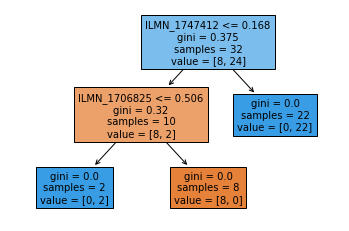

In [17]:
plot_tree(classifier, feature_names=concept_names, filled=True)
plt.show()

In [18]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
classifier = DecisionTreeClassifier(random_state=0)

explanations = []
for i, (train_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(), y.cpu().detach().numpy())):
    print(f'Split [{i+1}/{n_splits}]')
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model, explanation = train_nn(x_train, y_train, layers, device)
    explanations.append(explanation)
    
    y_preds = (model(x_test) > 0.5).cpu().detach().numpy()
    accuracy = accuracy_score(y_test.cpu().detach().numpy(), y_preds)
    print(f'\tAccuracy: {accuracy:.4f}')

Split [1/5]
	Accuracy: 1.0000
Split [2/5]
	Accuracy: 1.0000
Split [3/5]
	Accuracy: 1.0000
Split [4/5]
	Accuracy: 1.0000
Split [5/5]
	Accuracy: 1.0000


In [37]:
for i, explanation in enumerate(explanations):
    accuracy, preds = fol.base.test_explanation(explanation, 0, x_test, y_test)
    final_formula = fol.base.replace_names(explanation, concept_names)
    print(f'Split [{i+1}/{n_splits}] \n\t Formula: "{final_formula}" \n\t Test accuracy (formula): {accuracy*100:.2f}%\n')

Split [1/5] 
	 Formula: "(~ILMN_1708983 & ~ILMN_1745049 & ~ILMN_1777811) | (~ILMN_1708983 & ~ILMN_1745049 & ~ILMN_3243714) | (~ILMN_1708983 & ~ILMN_1777811 & ~ILMN_3243714)" 
	 Test accuracy (formula): 100.00%

Split [2/5] 
	 Formula: "(~ILMN_1708983 & ~ILMN_1745049) | (~ILMN_1708983 & ~ILMN_3243714)" 
	 Test accuracy (formula): 87.50%

Split [3/5] 
	 Formula: "(~ILMN_1708983 & ~ILMN_1745049) | (~ILMN_1708983 & ~ILMN_3243714)" 
	 Test accuracy (formula): 87.50%

Split [4/5] 
	 Formula: "~ILMN_1708983 & ~ILMN_1745049" 
	 Test accuracy (formula): 100.00%

Split [5/5] 
	 Formula: "(~ILMN_1708983 & ~ILMN_1745049) | (~ILMN_1708983 & ~ILMN_3243714)" 
	 Test accuracy (formula): 87.50%

